In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder # Import necessary preprocessing classes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap # Import shap for explanations

## Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load Data
file_path = '/content/drive/My Drive/loan_data.csv'

try:
    df = pd.read_csv(file_path)
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please double-check the file path and ensure the file exists in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")


First 5 rows of the dataset:


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [ ]:
df.LoanApproved.value_counts()

,count
LoanApproved,
0,15220
1,4780


In [4]:
with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df.head(5))

  ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  \
0         Master          22       13152            48       Married   
1      Associate          15       26045            48        Single   
2       Bachelor          26       17627            36       Married   
3    High School          34       37898            96        Single   
4      Associate          17        9184            36       Married   

   NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0                   2                 Own                  183   
1             

## Split Data

In [5]:
# Separate features (X) and target (y) from the original DataFrame
# Exclude 'LoanApproved' and 'RiskScore' from features for the initial split
X = df.drop(columns=['LoanApproved', 'RiskScore'])
y = df['LoanApproved']

# Split the data into training and testing sets before preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (16000, 34)
Testing features shape: (4000, 34)
Training target shape: (16000,)
Testing target shape: (4000,)


In [ ]:
y_train.value_counts()


,count
LoanApproved,
0,12176
1,3824


# Data preprocessing

## One-hot encoding

In [6]:
# Identify columns to one-hot encode
cols_to_encode = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']

# Apply one-hot encoding separately to X_train and X_test
# Fit on X_train, transform on both X_train and X_test
X_train_encoded = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=False,dtype= 'int')
X_test_encoded = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=False,dtype= 'int')
print(X_train_encoded)

# Align columns between X_train_encoded and X_test_encoded
train_cols = X_train_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_encoded[c] = 0

# Ensure the order of columns is the same
X_test_encoded = X_test_encoded[train_cols]


print("DataFrames after One-Hot Encoding.")
print("X_train_encoded shape:", X_train_encoded.shape)
print("X_test_encoded shape:", X_test_encoded.shape)

      ApplicationDate  Age  AnnualIncome  CreditScore  Experience  LoanAmount  \
15234      2059-09-17   50         34402          504          27       16368   
15766      2061-03-02   39         51561          612          15       24926   
16912      2064-04-21   23        119497          440           0       28380   
12481      2052-03-04   38         28425          616          16        9736   
1572       2022-04-22   43         55821          596          23       33557   
...               ...  ...           ...          ...         ...         ...   
9711       2044-08-03   48         84127          609          29       17138   
16422      2062-12-18   21         35506          506           0       45792   
6528       2035-11-16   40        112359          587          17       16731   
10125      2045-09-21   38         40653          560          15       17285   
19666      2071-11-05   58         31069          583          36       30596   

       LoanDuration  Number

## Check correlations

In [7]:
cols_to_drop_final = ['ApplicationDate']
X_train_encoded = X_train_encoded.drop(columns=[col for col in cols_to_drop_final if col in X_train_encoded.columns])
X_test_encoded = X_test_encoded.drop(columns=[col for col in cols_to_drop_final if col in X_test_encoded.columns])

In [8]:
correlations = X_train_encoded.apply(lambda col: col.corr(y_train))

# Filter for correlations > 0.2 or < -0.2
high_corr_features = correlations[(correlations > 0.2) | (correlations < -0.2)]

print("\n--- Features with high correlation to y_train (>|0.2|) ---")
print(high_corr_features.sort_values(ascending=False))


--- Features with high correlation to y_train (>|0.2|) ---
MonthlyIncome             0.604861
AnnualIncome              0.598094
LoanAmount               -0.238572
BaseInterestRate         -0.248131
InterestRate             -0.300835
TotalDebtToIncomeRatio   -0.408968
dtype: float64


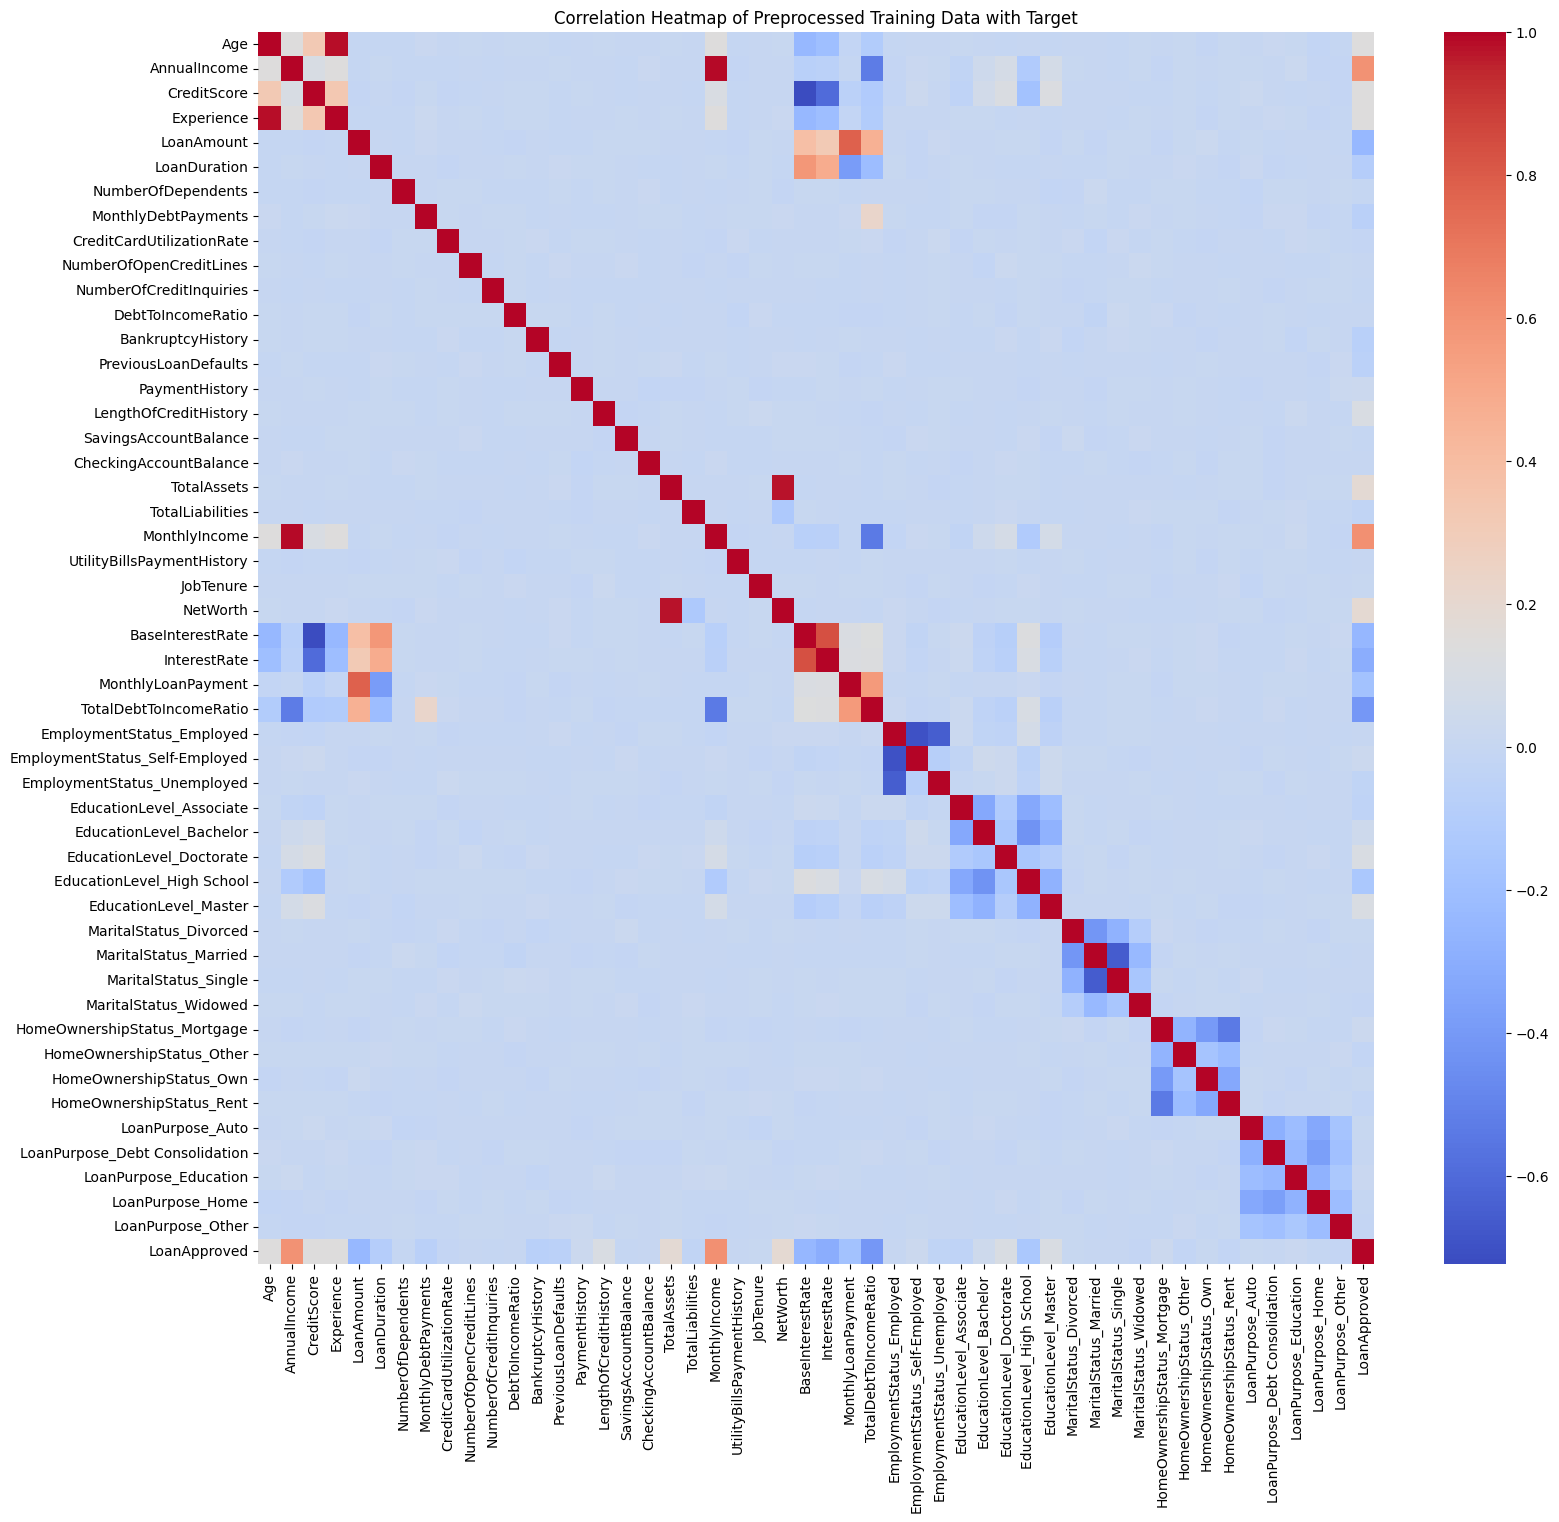

In [9]:
# Combine processed training features and target variable
train_data_with_target = X_train_encoded.copy()
train_data_with_target['LoanApproved'] = y_train

# Calculate the correlation matrix
correlation_matrix_full = train_data_with_target.corr()

# Plot the correlation heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix_full, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Preprocessed Training Data with Target')
plt.show()

In [10]:
print("\n--- Features with high correlation to each other (>|0.5|) ---")

# Calculate the absolute correlation matrix
abs_correlation_matrix = X_train_encoded.corr().abs()

# Select upper triangle of correlation matrix
upper = abs_correlation_matrix.where(np.triu(np.ones(abs_correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Print highly correlated pairs
print("Highly correlated feature pairs (correlation > 0.5):")
for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        if abs_correlation_matrix.iloc[i, j] > 0.5:
            print(f"- {abs_correlation_matrix.columns[i]} and {abs_correlation_matrix.columns[j]}: {abs_correlation_matrix.iloc[i, j]:.4f}")


--- Features with high correlation to each other (>|0.5|) ---
Highly correlated feature pairs (correlation > 0.5):
- Age and Experience: 0.9829
- AnnualIncome and MonthlyIncome: 0.9890
- AnnualIncome and TotalDebtToIncomeRatio: 0.5326
- CreditScore and BaseInterestRate: 0.7230
- CreditScore and InterestRate: 0.5992
- LoanAmount and MonthlyLoanPayment: 0.7813
- LoanDuration and BaseInterestRate: 0.5766
- TotalAssets and NetWorth: 0.9788
- MonthlyIncome and TotalDebtToIncomeRatio: 0.5396
- BaseInterestRate and InterestRate: 0.8344
- MonthlyLoanPayment and TotalDebtToIncomeRatio: 0.5659
- EmploymentStatus_Employed and EmploymentStatus_Self-Employed: 0.7024
- EmploymentStatus_Employed and EmploymentStatus_Unemployed: 0.6535
- MaritalStatus_Married and MaritalStatus_Single: 0.6576
- HomeOwnershipStatus_Mortgage and HomeOwnershipStatus_Rent: 0.5375


In [11]:
# Drop those columns because ApplicationDate is not useful and the other ones were highly correlated with another feature which is kept.
cols_to_drop_final = ['ApplicationDate','MonthlyIncome','TotalAssets', 'Experience','BaseInterestRate','MaritalStatus_Single','MonthlyLoanPayment','TotalDebtToIncomeRatio','CreditScore', 'EmploymentStatus_Employed','HomeOwnershipStatus_Mortgage']
X_train_encoded = X_train_encoded.drop(columns=[col for col in cols_to_drop_final if col in X_train_encoded.columns])
X_test_encoded = X_test_encoded.drop(columns=[col for col in cols_to_drop_final if col in X_test_encoded.columns])

## Scaling

In [ ]:
'''
# Identify numerical columns for scaling in X_train_encoded
numerical_cols_train = X_train_encoded.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
print(numerical_cols_train)

numerical_features_for_scaling_train = numerical_cols_train

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the identified numerical features in X_train
# Fit the scaler ONLY on the training data
X_train_processed = X_train_encoded.copy() # Create a copy to store processed data
X_train_processed[numerical_features_for_scaling_train] = scaler.fit_transform(X_train_processed[numerical_features_for_scaling_train])

# Apply the *same* scaler fitted on X_train to the numerical features in X_test
X_test_processed = X_test_encoded.copy() # Create a copy to store processed data
X_test_processed[numerical_features_for_scaling_train] = scaler.transform(X_test_processed[numerical_features_for_scaling_train]) # Use same columns as train



print("DataFrames after Numerical Feature Scaling and dropping original date columns.")
print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

# print("\nX_train_processed (first 5 rows):")
# display(X_train_processed.head())
# print("\nX_test_processed (first 5 rows):")
# display(X_test_processed.head())
'''

In [12]:
# Display descriptive statistics for the preprocessed training DataFrame
print("\nDescriptive Statistics of the Preprocessed Training DataFrame:")
display(X_train_encoded.describe())

# Display the correlation matrix for the preprocessed training data
print("\nCorrelation Matrix for Preprocessed Training Data:")
correlation_matrix_train = X_train_encoded.corr()
display(correlation_matrix_train.head())


Descriptive Statistics of the Preprocessed Training DataFrame:


,Age,AnnualIncome,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,...,MaritalStatus_Married,MaritalStatus_Widowed,HomeOwnershipStatus_Other,HomeOwnershipStatus_Own,HomeOwnershipStatus_Rent,LoanPurpose_Auto,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
count,16000.000000,16000.000000,16000.000000,16000.0000,16000.00000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,...,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,39.730938,59325.075563,24902.192062,54.0330,1.51425,455.502000,0.286256,3.022063,0.989625,0.285489,...,0.500250,0.051687,0.101312,0.197000,0.307000,0.203813,0.249812,0.151125,0.295563,0.099687
std,11.654110,40332.333800,13420.296053,24.6066,1.38827,241.253884,0.160072,1.739077,0.983592,0.160199,...,0.500016,0.221402,0.301752,0.397745,0.461264,0.402844,0.432918,0.358182,0.456309,0.299592
min,18.000000,15000.000000,3674.000000,12.0000,0.00000,60.000000,0.002672,0.000000,0.000000,0.001720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,31926.750000,15652.000000,36.0000,0.00000,287.000000,0.160303,2.000000,0.000000,0.160902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,48754.500000,21918.000000,48.0000,1.00000,403.000000,0.266116,3.000000,1.000000,0.263977,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,74543.250000,30837.250000,72.0000,2.00000,565.000000,0.390937,4.000000,2.000000,0.389222,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,80.000000,485341.000000,184732.000000,120.0000,5.00000,2919.000000,0.917380,13.000000,7.000000,0.902253,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Correlation Matrix for Preprocessed Training Data:


,Age,AnnualIncome,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,...,MaritalStatus_Married,MaritalStatus_Widowed,HomeOwnershipStatus_Other,HomeOwnershipStatus_Own,HomeOwnershipStatus_Rent,LoanPurpose_Auto,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
Age,1.000000,0.142793,-0.007874,-0.007927,-0.004215,0.015001,-0.001377,0.004977,-0.002217,0.009284,...,0.002076,0.004567,0.005317,-0.012445,0.007647,0.001031,0.013534,0.008499,-0.016544,-0.005905
AnnualIncome,0.142793,1.000000,-0.006485,0.005024,-0.004243,-0.003230,-0.009246,0.000223,-0.005258,-0.000042,...,-0.000181,0.004023,0.006644,0.000856,0.005796,0.005729,-0.000943,0.018779,-0.009826,-0.013826
LoanAmount,-0.007874,-0.006485,1.000000,-0.001782,-0.006879,0.013941,0.002545,0.001611,-0.005247,-0.012426,...,-0.013537,0.008240,0.008095,0.019145,-0.007087,0.004701,-0.003055,0.003571,-0.001934,-0.003230
LoanDuration,-0.007927,0.005024,-0.001782,1.000000,0.000513,0.001504,-0.012773,-0.002725,0.001223,0.005630,...,-0.004756,0.002372,0.013338,0.001482,-0.012259,0.017065,-0.012497,-0.003630,-0.001036,0.001029
NumberOfDependents,-0.004215,-0.004243,-0.006879,0.000513,1.000000,0.000706,0.007903,0.005837,-0.006758,-0.007911,...,0.020885,-0.009005,0.009311,-0.008480,-0.007711,-0.016537,0.003904,0.004593,0.001491,0.008832


In [14]:
print("Remaining features after preprocessing:")
for feature in X_train_encoded.columns.tolist():
    print(feature)

Remaining features after preprocessing:
Age
AnnualIncome
LoanAmount
LoanDuration
NumberOfDependents
MonthlyDebtPayments
CreditCardUtilizationRate
NumberOfOpenCreditLines
NumberOfCreditInquiries
DebtToIncomeRatio
BankruptcyHistory
PreviousLoanDefaults
PaymentHistory
LengthOfCreditHistory
SavingsAccountBalance
CheckingAccountBalance
TotalLiabilities
UtilityBillsPaymentHistory
JobTenure
NetWorth
InterestRate
EmploymentStatus_Self-Employed
EmploymentStatus_Unemployed
EducationLevel_Associate
EducationLevel_Bachelor
EducationLevel_Doctorate
EducationLevel_High School
EducationLevel_Master
MaritalStatus_Divorced
MaritalStatus_Married
MaritalStatus_Widowed
HomeOwnershipStatus_Other
HomeOwnershipStatus_Own
HomeOwnershipStatus_Rent
LoanPurpose_Auto
LoanPurpose_Debt Consolidation
LoanPurpose_Education
LoanPurpose_Home
LoanPurpose_Other


# Classifiers

## Logistic Regression

In [15]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
print("\nTraining Logistic Regression model...")
lr_model.fit(X_train_encoded, y_train)
print("Logistic Regression Model training complete.")


Training Logistic Regression model...
Logistic Regression Model training complete.



Logistic Regression Model Evaluation:
Accuracy: 0.9040
Precision: 0.8303
Recall: 0.7521
F1-Score: 0.7892
ROC-AUC: 0.9534


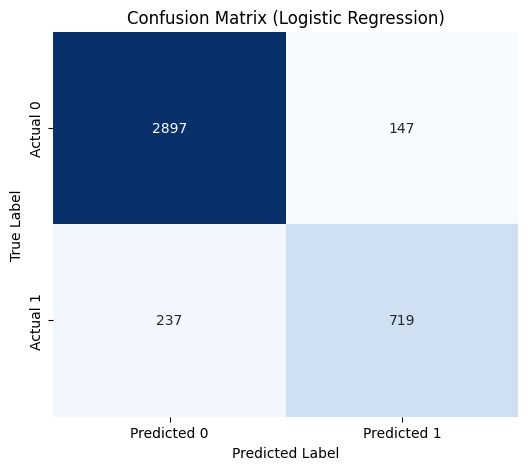

In [16]:
# Evaluate the Logistic Regression model on the test data
y_pred_lr = lr_model.predict(X_test_encoded)
y_pred_proba_lr = lr_model.predict_proba(X_test_encoded)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest


Training Random Forest Classifier model...
Random Forest Model training complete.

Random Forest Model Evaluation:
Accuracy: 0.9193
Precision: 0.9063
Recall: 0.7385
F1-Score: 0.8138
ROC-AUC: 0.9739


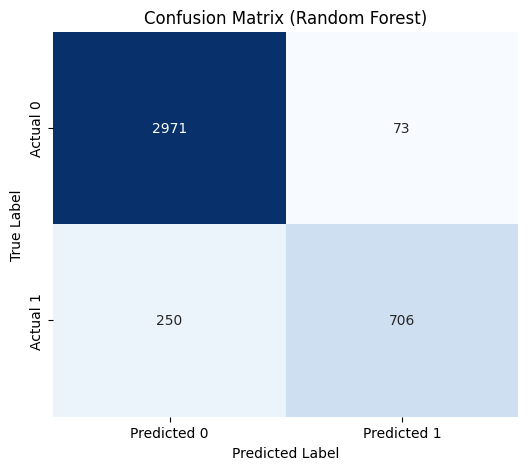

In [17]:
# Initialize and train the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)
print("\nTraining Random Forest Classifier model...")
rf_model.fit(X_train_encoded, y_train)
print("Random Forest Model training complete.")

# Evaluate the Random Forest model on the preprocessed test data
y_pred_rf = rf_model.predict(X_test_encoded)
y_pred_proba_rf = rf_model.predict_proba(X_test_encoded)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## XGBoost


Training XGBoost Classifier model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:31:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model training complete.

XGBoost Model Evaluation:
Accuracy: 0.9387
Precision: 0.8835
Recall: 0.8567
F1-Score: 0.8699
ROC-AUC: 0.9835


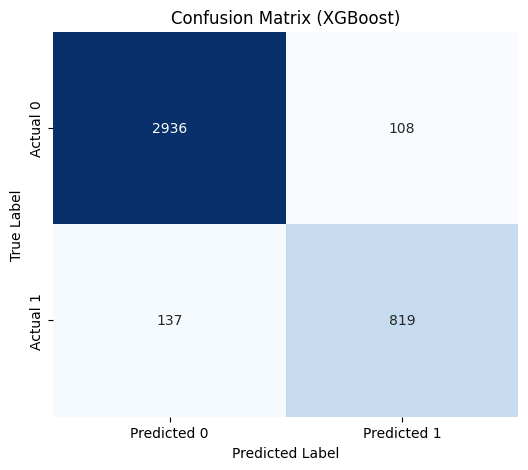

In [18]:
# Initialize and train the XGBoost Classifier model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')
print("\nTraining XGBoost Classifier model...")
xgb_model.fit(X_train_encoded, y_train)
print("XGBoost Model training complete.")

# Evaluate the XGBoost model on the preprocessed test data
y_pred_xgb = xgb_model.predict(X_test_encoded)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_encoded)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

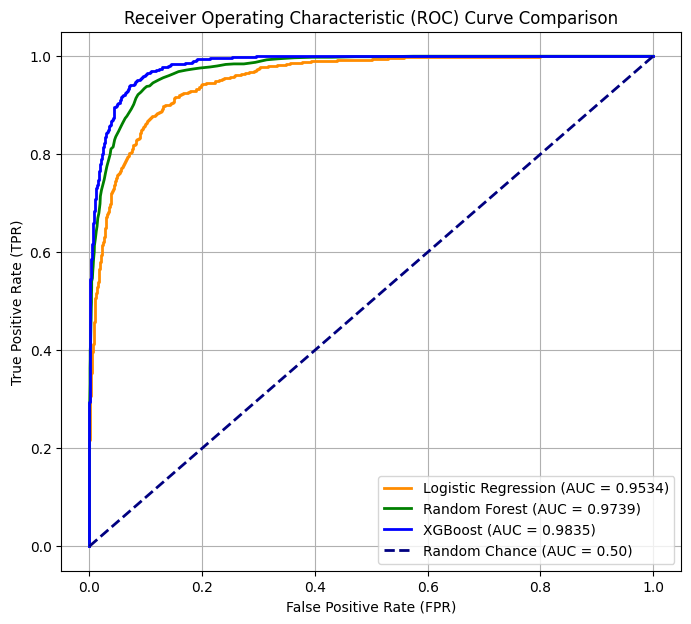

In [19]:
# Plot ROC curves for model comparison
y_pred_proba_lr = lr_model.predict_proba(X_test_encoded)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test_encoded)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_test_encoded)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 7))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# SHAP values

In [20]:
!pip install shap

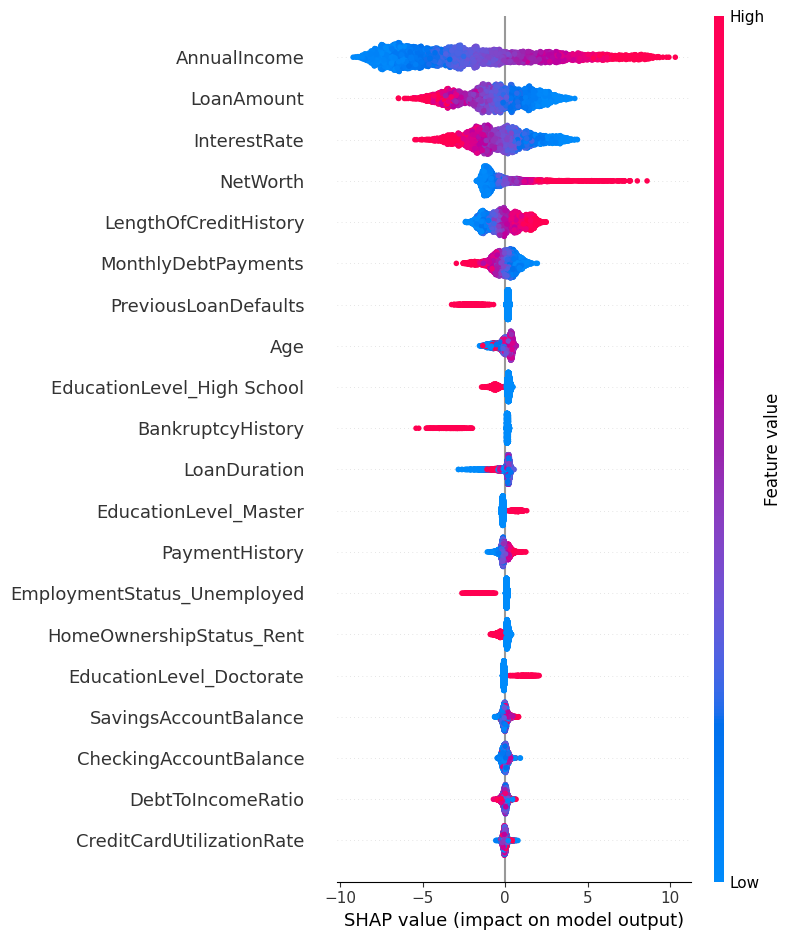

In [21]:
#explainer_xgb = shap.TreeExplainer(xgb_model,X_test_processed)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values = explainer_xgb(X_test_encoded)

# Beeswarm summary plot
shap.summary_plot(shap_values, X_test_encoded)



In [22]:
shap_values.values[0]

array([ 1.4973597e-01, -5.9996719e+00, -3.2969599e+00,  1.2373730e-01,
        6.2608987e-02, -8.7346303e-01,  1.6011147e-01,  2.2916364e-02,
       -3.5240280e-03, -4.4209443e-02,  9.4945602e-02, -1.7511126e+00,
       -3.4418821e-01, -1.1978807e+00, -9.2746340e-02,  3.4509194e-01,
       -6.7958552e-03,  2.7615598e-01, -1.2212582e-01, -1.3210092e+00,
       -7.5188845e-01, -7.0082694e-03,  7.1386166e-02, -1.8145493e-01,
       -2.5985446e-02, -1.1787541e-01, -2.5256883e-02, -1.7087243e-01,
        8.9449447e-04, -3.5891525e-02,  6.4559523e-03,  2.1239746e-02,
       -1.9479746e-02,  8.2193099e-02,  7.7352650e-04, -7.1837157e-03,
        4.1301817e-02, -1.6206209e-02, -1.3991044e-02], dtype=float32)

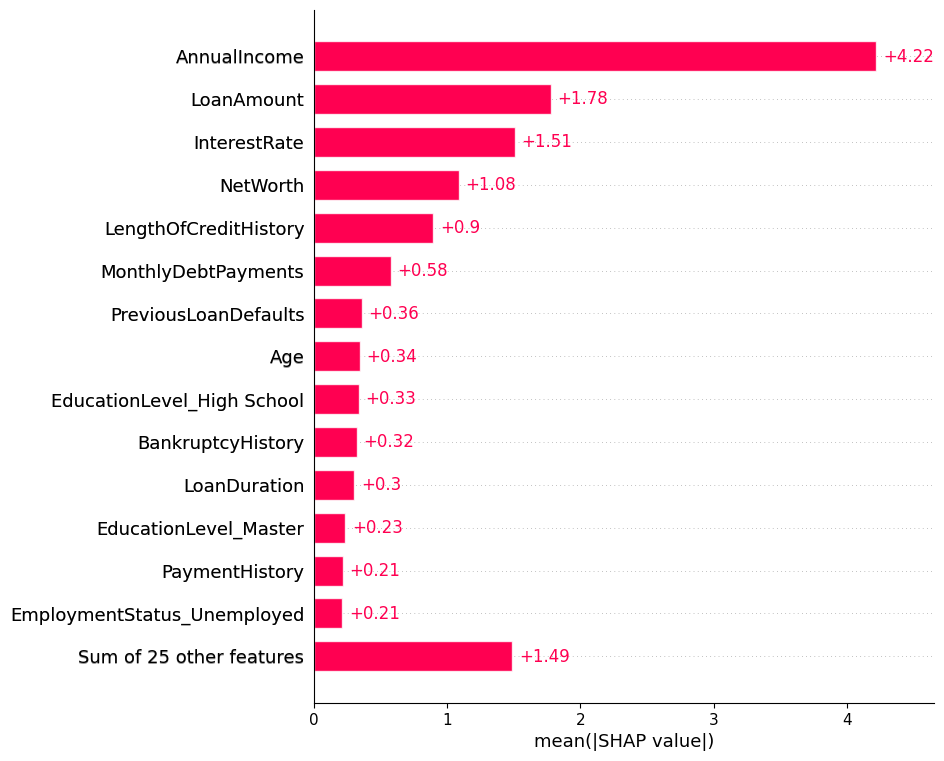

In [23]:
shap.plots.bar(shap_values, max_display=15)

In [24]:
print("Generating SHAP Explanation for a Single Instance")

# Select one instance
instance = X_test_encoded.iloc[[0]]

# Get SHAP values
shap_values = explainer_xgb(instance)
print(shap_values)

print("SHAP values calculated for a particular instance.")
print(f"Expected value (base value): {shap_values.base_values[0]:.4f}")

shap.initjs()

# Force plot
shap.force_plot(shap_values.base_values[0], shap_values.values[0], instance)




Generating SHAP Explanation for a Single Instance
.values =
array([[ 1.4973597e-01, -5.9996719e+00, -3.2969599e+00,  1.2373730e-01,
         6.2608987e-02, -8.7346303e-01,  1.6011147e-01,  2.2916364e-02,
        -3.5240280e-03, -4.4209443e-02,  9.4945602e-02, -1.7511126e+00,
        -3.4418821e-01, -1.1978807e+00, -9.2746340e-02,  3.4509194e-01,
        -6.7958552e-03,  2.7615598e-01, -1.2212582e-01, -1.3210092e+00,
        -7.5188845e-01, -7.0082694e-03,  7.1386166e-02, -1.8145493e-01,
        -2.5985446e-02, -1.1787541e-01, -2.5256883e-02, -1.7087243e-01,
         8.9449447e-04, -3.5891525e-02,  6.4559523e-03,  2.1239746e-02,
        -1.9479746e-02,  8.2193099e-02,  7.7352650e-04, -7.1837157e-03,
         4.1301817e-02, -1.6206209e-02, -1.3991044e-02]], dtype=float32)

.base_values =
array([-1.4239979], dtype=float32)

.data =
array([[3.90000000e+01, 2.20740000e+04, 6.00150000e+04, 4.80000000e+01,
        0.00000000e+00, 5.85000000e+02, 9.69175179e-02, 3.00000000e+00,
        0.00000

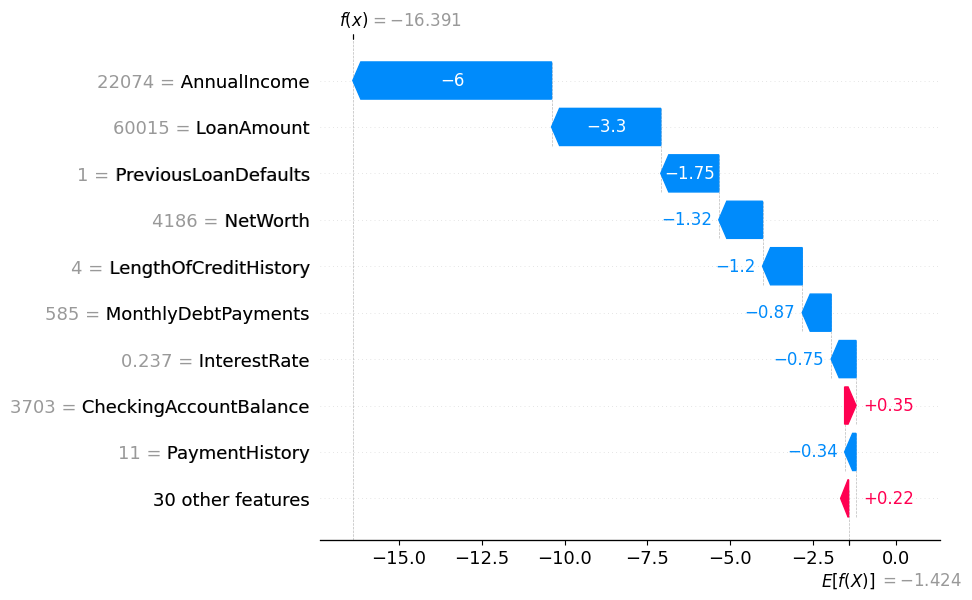

In [25]:
# Waterfall plot
shap.plots.waterfall(shap.Explanation(values=shap_values.values[0], base_values=shap_values.base_values[0], data=shap_values.data[0], feature_names=shap_values.feature_names))



In [26]:
import shap
import joblib
import pandas as pd
import numpy as np
import os

# Create export directory
os.makedirs("/content/drive/MyDrive/exports", exist_ok=True)

# 1. Save the trained XGBoost model
joblib.dump(xgb_model, "/content/drive/MyDrive/exports/xgb_model_final.pkl")

# 2. Save the processed test set (X values)
X_test_encoded.to_csv("/content/drive/MyDrive/exports/X_test_processed_final.csv", index=False)

# 3. Save the true labels (y values)
pd.Series(y_test).to_csv("/content/drive/MyDrive/exports/y_test_final.csv", index=False)

# Convert SHAP values to shap.Explanation object if they are not already
if isinstance(shap_values, np.ndarray):
    shap_values = shap.Explanation(values=shap_values, base_values=explainer_xgb.expected_value, data=X_test_encoded)

# Now you can safely save the SHAP values
np.save("/content/drive/MyDrive/exports/shap_values_final.npy", shap_values.values)
print("SHAP values saved.")


SHAP values saved.


In [27]:
# Get feature names from the processed test set
feature_names = X_test_encoded.columns

# Get SHAP values for a particular instance
shap_values_particular_instance = shap_values[0]

# Print feature names and their corresponding SHAP values
print("Feature Name | SHAP Value")
print("-------------|------------")
for feature, shap_value in zip(feature_names, shap_values_particular_instance.values): # Access the values attribute
    print(f"{feature:12} | {shap_value:.4f}")

Feature Name | SHAP Value
-------------|------------
Age          | 0.1497
AnnualIncome | -5.9997
LoanAmount   | -3.2970
LoanDuration | 0.1237
NumberOfDependents | 0.0626
MonthlyDebtPayments | -0.8735
CreditCardUtilizationRate | 0.1601
NumberOfOpenCreditLines | 0.0229
NumberOfCreditInquiries | -0.0035
DebtToIncomeRatio | -0.0442
BankruptcyHistory | 0.0949
PreviousLoanDefaults | -1.7511
PaymentHistory | -0.3442
LengthOfCreditHistory | -1.1979
SavingsAccountBalance | -0.0927
CheckingAccountBalance | 0.3451
TotalLiabilities | -0.0068
UtilityBillsPaymentHistory | 0.2762
JobTenure    | -0.1221
NetWorth     | -1.3210
InterestRate | -0.7519
EmploymentStatus_Self-Employed | -0.0070
EmploymentStatus_Unemployed | 0.0714
EducationLevel_Associate | -0.1815
EducationLevel_Bachelor | -0.0260
EducationLevel_Doctorate | -0.1179
EducationLevel_High School | -0.0253
EducationLevel_Master | -0.1709
MaritalStatus_Divorced | 0.0009
MaritalStatus_Married | -0.0359
MaritalStatus_Widowed | 0.0065
HomeOwnershi